In [1]:
import sys

sys.path.insert(0, '..')

## Setup the model area

In [2]:
from morpheus.project.types.discretization import SpatialDiscretization
from morpheus.project.types.discretization.spatial import Rotation, Grid, Crs
from morpheus.project.types.geometry import Polygon

polygon = Polygon(
  type='Polygon',
  coordinates=[[
    (13.92, 50.964),
    (13.92, 50.966),
    (13.925, 50.966),
    (13.925, 50.964),
    (13.92, 50.964)
  ]]
)

rotation = Rotation(0)

grid = Grid.cartesian_from_polygon(polygon=polygon, n_cols=100, n_rows=50, rotation=rotation)
spatial_discretization = SpatialDiscretization.from_geometry_with_grid(
  geometry=polygon,
  grid=grid,
  crs=Crs.from_str('EPSG:4326')
)

## Setup Time Discretization

In [3]:
from morpheus.project.types.discretization.time.TimeUnit import TimeUnit
from morpheus.project.types.discretization.time.Stressperiods import StartDateTime, StressPeriodCollection, \
  StressPeriod, NumberOfTimeSteps, TimeStepMultiplier, IsSteadyState
from morpheus.project.types.discretization.time import TimeDiscretization
from datetime import datetime

time_discretization = TimeDiscretization(
  start_date_time=StartDateTime.from_datetime(datetime(2020, 1, 1)),
  end_date_time=StartDateTime.from_datetime(datetime(2020, 12, 31)),
  stress_periods=StressPeriodCollection([
    StressPeriod(
      start_date_time=StartDateTime.from_datetime(datetime(2020, 1, 1)),
      number_of_time_steps=NumberOfTimeSteps(1),
      time_step_multiplier=TimeStepMultiplier(1),
      steady_state=IsSteadyState.yes()
    ),
  ]),
  time_unit=TimeUnit.days()
)

# Setup Model

In [4]:
from morpheus.project.types.Model import Model

model = Model.new()
model = model.with_updated_time_discretization(time_discretization)
model = model.with_updated_spatial_discretization(spatial_discretization=spatial_discretization)

In [5]:
import folium

m = folium.Map(tiles="cartodbpositron", crs="EPSG3857", zoom_start=12, location=[50.965, 13.922])
m.add_child(folium.GeoJson(polygon.as_geojson()))

m.fit_bounds(m.get_bounds())
m

# Setup Wells

In [6]:
from morpheus.project.types.boundaries.WellObservation import WellObservationValue, PumpingRate
from morpheus.project.types.geometry import Point
from morpheus.project.types.boundaries.Boundary import BoundaryName, BoundaryCollection, WellBoundary

boundary_collection = BoundaryCollection.new()

well_boundary_1 = WellBoundary.from_geometry(
  name=BoundaryName('well_1'),
  geometry=Point((13.921, 50.965)),
  grid=grid,
  affected_layers=[model.layers[0].layer_id],
  data=[
    WellObservationValue(
      date_time=StartDateTime.from_datetime(datetime(2020, 1, 1)),
      pumping_rate=PumpingRate.from_float(-1000),
    )
  ]
)

well_boundary_2 = WellBoundary.from_geometry(
  name=BoundaryName('well_2'),
  geometry=Point((13.923, 50.9655)),
  grid=grid,
  affected_layers=[model.layers[0].layer_id],
  data=[
    WellObservationValue(
      date_time=StartDateTime.from_datetime(datetime(2020, 1, 1)),
      pumping_rate=PumpingRate.from_float(1000),
    ),
  ]
)

boundary_collection.add_boundary(well_boundary_1)
boundary_collection.add_boundary(well_boundary_2)

model = model.with_updated_boundaries(boundaries=boundary_collection)

m.add_child(folium.GeoJson(well_boundary_1.as_geojson()))
m.add_child(folium.GeoJson(well_boundary_1.affected_cells.to_geojson(grid).as_geojson()))
m.add_child(folium.GeoJson(well_boundary_2.as_geojson()))
m.add_child(folium.GeoJson(well_boundary_2.affected_cells.to_geojson(grid).as_geojson()))

m.fit_bounds(m.get_bounds())
m

In [7]:
from morpheus.project.infrastructure.calculation.engines.modflow_2005.packages.WelPackageMapper import \
  calculate_wel_boundary_stress_period_data

result = calculate_wel_boundary_stress_period_data(
  spatial_discretization=spatial_discretization,
  time_discretization=time_discretization,
  layers=model.layers,
  wel_boundary=well_boundary_1,
)
print(result.to_dict())

result = calculate_wel_boundary_stress_period_data(
  spatial_discretization=spatial_discretization,
  time_discretization=time_discretization,
  layers=model.layers,
  wel_boundary=well_boundary_2,
)
print(result.to_dict())

{0: [[0, 25, 19, -1000.0]]}
{0: [[0, 12, 59, 1000.0]]}


## Calculate

In [8]:
from morpheus.project.infrastructure.calculation.services.CalculationService import CalculationService
from morpheus.project.types.calculation.CalculationProfile import CalculationProfile, CalculationEngineType

calculation = CalculationService.calculate(model=model, profile=CalculationProfile.new(CalculationEngineType.MF2005))

FloPy is using the following executable to run the model: ../../../../../../Users/ralf/Projects/inowas/morpheus/src/backend/.venv/bin/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: mf2005.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2026/02/15 13:40:58

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2026/02/15 13:40:58
 Elapsed run time:  0.012 Seconds

  Normal termination of simulation


In [9]:
calculation.check_model_log

Log(log=['type,package,k,i,j,value,desc'])

In [10]:
calculation.get_result()

CalculationResult(type=<CalculationResultType.SUCCESS: 'success'>, message='Calculation finished successfully', files=['mf2005.list', 'mf2005.dis', 'mf2005.nam', 'mf2005.bas', 'mf2005.lpf', 'mf2005.pcg', 'mf2005.oc', 'mf2005.wel', 'mf2005.hds'], flow_head_results=AvailableResults(times=[365.0], kstpkper=[(0, 0)], number_of_layers=1, number_of_observations=0, min_value=-989.2379760742188, max_value=913.463623046875), flow_drawdown_results=None, flow_budget_results=AvailableResults(times=[365.0], kstpkper=[(0, 0)], number_of_layers=0, number_of_observations=0, min_value=None, max_value=None), transport_concentration_results=None, transport_budget_results=None, packages=['DIS', 'BAS6', 'WEL', 'PCG', 'LPF', 'OC'])

In [11]:
calculation.read_flow_head(0, 0)

[[-306.3670959472656,
  -305.96240234375,
  -305.151611328125,
  -303.9325866699219,
  -302.302001953125,
  -300.255615234375,
  -297.7879943847656,
  -294.8931884765625,
  -291.5646057128906,
  -287.79510498046875,
  -283.5773010253906,
  -278.9036865234375,
  -273.7669982910156,
  -268.1600036621094,
  -262.0762023925781,
  -255.50970458984375,
  -248.45559692382812,
  -240.91000366210938,
  -232.8701934814453,
  -224.3345947265625,
  -215.30340576171875,
  -205.77789306640625,
  -195.76100158691406,
  -185.2572021484375,
  -174.2720947265625,
  -162.81300354003906,
  -150.8883056640625,
  -138.50759887695312,
  -125.68180084228516,
  -112.42279815673828,
  -98.74330139160156,
  -84.65699768066406,
  -70.17870330810547,
  -55.32389831542969,
  -40.10929870605469,
  -24.552400588989258,
  -8.67240047454834,
  7.510300159454346,
  23.97330093383789,
  40.69179916381836,
  57.63840103149414,
  74.7822036743164,
  92.0884017944336,
  109.51719665527344,
  127.02300262451172,
  144.553802

In [12]:
result = calculation.calculation_result

In [13]:
head = calculation.read_flow_head(idx=0, layer=0)

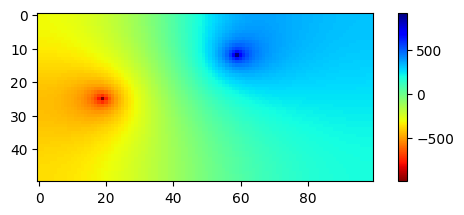

In [14]:
import matplotlib.pyplot as plt

plt.subplot(2, 1, 1)
plt.imshow(head, cmap='jet_r')
plt.colorbar()
plt.show()

In [15]:
calculation.read_flow_drawdown(idx=0, layer=0)

[]

In [16]:
calculation.read_flow_budget(idx=0, incremental=False)

{'STORAGE_IN': 0.0,
 'CONSTANT_HEAD_IN': 0.0,
 'WELLS_IN': 365000.0,
 'TOTAL_IN': 365000.0,
 'STORAGE_OUT': -0.0,
 'CONSTANT_HEAD_OUT': -0.0,
 'WELLS_OUT': -365000.0,
 'TOTAL_OUT': -365000.0,
 'IN-OUT': 0.0,
 'PERCENT_DISCREPANCY': 0.0,
 'tslen': 0.75149995}

In [17]:
calculation.read_flow_budget(idx=0, incremental=True)

{'STORAGE_IN': 0.0,
 'CONSTANT_HEAD_IN': 0.0,
 'WELLS_IN': 1000.0,
 'TOTAL_IN': 1000.0,
 'STORAGE_OUT': -0.0,
 'CONSTANT_HEAD_OUT': -0.0,
 'WELLS_OUT': -1000.0,
 'TOTAL_OUT': -1000.0,
 'IN-OUT': 0.0,
 'PERCENT_DISCREPANCY': 0.0,
 'tslen': 365.0}